**MM Comments**

After review, I think we should also include a brief analysis concerning the public utility sector (22 and 221).  Perhaps exploring the relationship to non public and establishing a "responsibility" metric.

If public utilities are performing at or near the best "non-violations", can we establish this as a baseline and then compare industrial sectors that are closer to that responsibility line?



<u>**Purpose, Process, Payoff**</u>

**Purpose:** This notebook investigates patterns in NPDES (National Pollutant Discharge Elimination System) violations by analyzing facility-level data from the EPA ECHO database, with a focus on identifying industry sectors associated with higher violation rates.

**Process:** NPDES datasets were merged using the NPDES ID as the unique key. The data was then:
- Aggregated to count violations per NPDES ID and visualize their frequency
- Grouped by NAICS codes to classify industries
- Analyzed at various levels of NAICS code—starting with 1-digit sectors (broad industry categories), then narrowing to 2-digit and 3-digit subcategories
- Visualized using box and violin plots to highlight which sectors contribute most to violations, with sector 21 (Mining) and specifically 212 (Coal Mining) identified as a standout
- Created a pie chart displaying the distribution of violation types
- Ended with statistical testing to assess whether industry type significantly influences violation frequency, which revealed no statistically significant impact

**Payoff:** The notebook provides a structured exploration of how industrial classification relates to environmental compliance. While certain sub-sectors appear more frequently in high-violation categories, statistical analysis helps temper assumptions and guides more nuanced interpretations for environmental oversight and policy planning.



## Load Datasets and Merge

First, read the NPDES_NAICS and NPDES_EFF_VIOLATIONS csv files. Also, note that I am only grabbing a select few columns from each dataset. This is because these files are MASSIVE and would take forever without limiting what I am pulling in. After reading the csv files, merge them on NPDES_ID. Then, bring the NAICS_CODE and NAICS_DESC columns over. This will allow for analyses of different industries and their violations. Once merged, I drop null values for NAICS_CODE, as that is all I care to see. If concerned about the amount of records, see note at the bottom of the notebook.

In [2]:
from sqlalchemy import create_engine, text
import pandas as pd
import os
from dotenv import load_dotenv

load_dotenv()

naics_usecols = ["NPDES_ID", "NAICS_CODE"]
npdes_usecols = ["NPDES_ID", "NPDES_VIOLATION_ID", "VIOLATION_TYPE_CODE", "VIOLATION_CODE"]


df_naics = pd.read_csv(f'./EPA_Data/NPDES_NAICS.csv',
                       low_memory=False)

df_npdes = pd.read_csv(f'./EPA_Data/NPDES_EFF_VIOLATIONS.csv',
                       usecols=npdes_usecols,
                       low_memory=False)

newdf = pd.merge(df_npdes, df_naics[["NPDES_ID", "NAICS_CODE", "NAICS_DESC"]], on = "NPDES_ID", how = 'left')

newdf["NAICS_3digit"] = newdf["NAICS_CODE"].astype(str).str[:3].where(newdf["NAICS_CODE"].notna())

notnanaics = newdf[newdf["NAICS_3digit"].notna()]
#notnanaics

D90 is the most common violation code. Violation is for 'limited value overdue', which looks like it is a reporting violation. D80 is also a reporting violation. E90 is 3rd most common. This is an effluent violation for exceeding a max or min discharge limit. These are the only 3 codes in this set.

#### Dataframe Exploration

In [2]:
#df_npdes

,NPDES_ID,NPDES_VIOLATION_ID,VIOLATION_TYPE_CODE,VIOLATION_CODE
0,KY0054691,2401210169,NaN,D90
1,IDG130102,600111060,NaN,D80
2,MO0003263,2405191972,NaN,D90
3,OK0040410,1202311315,NaN,D90
4,AL0022845,1600359920,NaN,D90
...,...,...,...,...
45168339,COG318098,3665747113,NaN,D80
45168340,CA0110175,3673752079,NaN,D90
45168341,AR0050261,3675976064,NaN,E90
45168342,COG318063,3662042162,NaN,D90


In [3]:
#df_naics

,NPDES_ID,NAICS_CODE,NAICS_DESC,PRIMARY_INDICATOR_FLAG
0,AK0000272,311710,Seafood Product Preparation and Packaging,Y
1,AK0000370,424710,Petroleum Bulk Stations and Terminals,Y
2,AK0000507,325311,Nitrogenous Fertilizer Manufacturing,Y
3,AK0000841,324110,Petroleum Refineries,Y
4,AK0001155,211130,Natural Gas Extraction,Y
...,...,...,...,...
193300,WYPU00103,333132,Oil and Gas Field Machinery and Equipment Manu...,Y
193301,WYR001454,484220,Specialized Freight [except Used Goods] Trucki...,Y
193302,WYR001454,562112,Hazardous Waste Collection,N
193303,WYR001545,213112,Support Activities For Oil and Gas Operations,Y


In [4]:
#newdf

,NPDES_ID,NPDES_VIOLATION_ID,VIOLATION_TYPE_CODE,VIOLATION_CODE,NAICS_CODE,NAICS_DESC,NAICS_3digit
0,KY0054691,2401210169,NaN,D90,321211.0,Hardwood Veneer and Plywood Manufacturing,321
1,IDG130102,600111060,NaN,D80,NaN,NaN,NaN
2,MO0003263,2405191972,NaN,D90,NaN,NaN,NaN
3,OK0040410,1202311315,NaN,D90,221320.0,Sewage Treatment Facilities,221
4,AL0022845,1600359920,NaN,D90,NaN,NaN,NaN
...,...,...,...,...,...,...,...
45732921,CA0110175,3673752079,NaN,D90,NaN,NaN,NaN
45732922,AR0050261,3675976064,NaN,E90,221320.0,Sewage Treatment Facilities,221
45732923,COG318063,3662042162,NaN,D90,NaN,NaN,NaN
45732924,IN0022781,2200332321,NaN,E90,221320.0,Sewage Treatment Facilities,221


There are ~335k facilities w NPDES permits (Google). df_npdes has 120,750 unique NPDES_ID's. df_naics has 177,203. NotNaNaics dataframe has 29,451 NPDES_ID's. This implies that the NPDES_ID's that we have from the naics dataframe hardly overlap with those in the NPDES dataframe we are using. Definitely a possibility, especially if the 335k figure is correct.

## Analyses

Create a histogram that shows the amount of violations on the x-axis, and the number of NPDES ID's that fall within the bin of violations. Bin sizes are very small, around 5 violations.

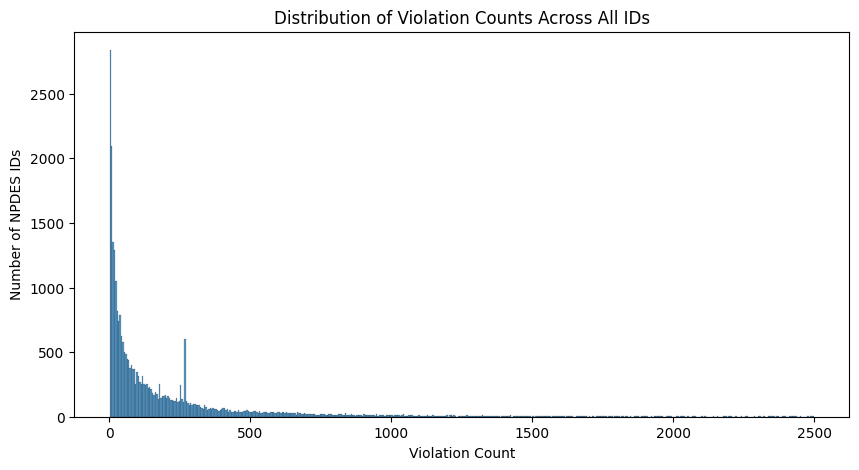

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

npdesgroup = notnanaics.groupby("NPDES_ID").agg(
    violation_count=("NPDES_ID", "count")
).reset_index()

filterednpdes = npdesgroup[npdesgroup['violation_count'] < 2500]  # Change 100 as needed

plt.figure(figsize=(10, 5))
sns.histplot(filterednpdes['violation_count'], binwidth=5, kde=False)
plt.xlabel('Violation Count')
plt.ylabel('Number of NPDES IDs')
plt.title('Distribution of Violation Counts Across All IDs')
plt.show()

Define a new dataframe called naicsgroup. This dataframe groups violations by the NAICS code and shows the amount of violations for each NAICS code.

In [4]:
naicsgroup = notnanaics.groupby("NAICS_3digit").agg(
    violation_count=("NPDES_ID", "count")
).reset_index()
naicsgroup

,NAICS_3digit,violation_count
0,111,6397
1,112,99482
2,113,9513
3,114,3765
4,115,7110
...,...,...
90,925,1097
91,926,6996
92,927,133
93,928,25397


Create a box plot. First, define a new field called NAICS sector. The sector is the 1st digit of the NAICS code. This makes it easier to show the broad perspective of violations across industries. With this plot, you can see that sector 2 has significantly more violations than any other groups. Some locations in sector 2 have close to 3 million violations.

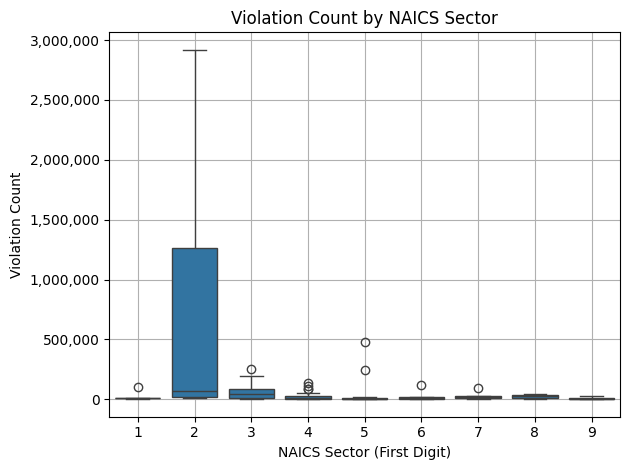

In [5]:
from matplotlib.ticker import FuncFormatter
import logging
import matplotlib

matplotlib.set_loglevel("warning")
naicsgroup['NAICS_SECTOR'] = naicsgroup['NAICS_3digit'].str[0]

sns.boxplot(x='NAICS_SECTOR', y='violation_count', data=naicsgroup)

formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('NAICS Sector (First Digit)')
plt.ylabel('Violation Count')
plt.title('Violation Count by NAICS Sector')
plt.grid(True)
plt.tight_layout()
plt.show()

Create violin plots to go more in depth into Sector 2. Once the first one is shown, recognize that group 21 has significantly more violations than the others. So, expand on that and show all 3-digit codes that start with 21. This then shows us that 212 has many violations. 212 is the Surface Coal Mining industry.

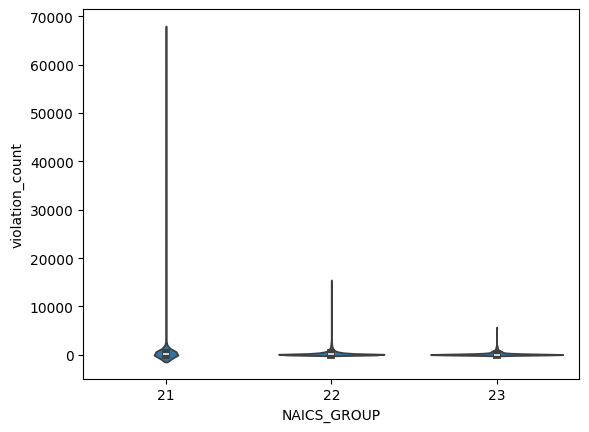

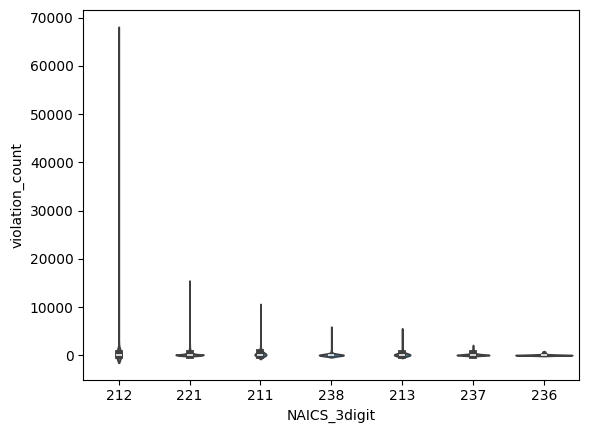

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

violation_counts = notnanaics['NPDES_ID'].value_counts().reset_index()
violation_counts.columns = ['NPDES_ID', 'violation_count']

merged = pd.merge(violation_counts, notnanaics[['NPDES_ID', 'NAICS_3digit']], on='NPDES_ID', how='left')

merged = merged.drop_duplicates(subset= 'NPDES_ID')
merged['NAICS_GROUP'] = merged['NAICS_3digit'].str[:2]
subset = merged[merged['NAICS_GROUP'].str.startswith('2')]


sns.violinplot(x='NAICS_GROUP', y='violation_count', data=subset)
plt.show()

sns.violinplot(x='NAICS_3digit', y='violation_count', data=subset)
plt.show()

Create a pie chart showing the distribution of violation types. This will show how frequently different violations show. This dataframe only has 3 different violation types.

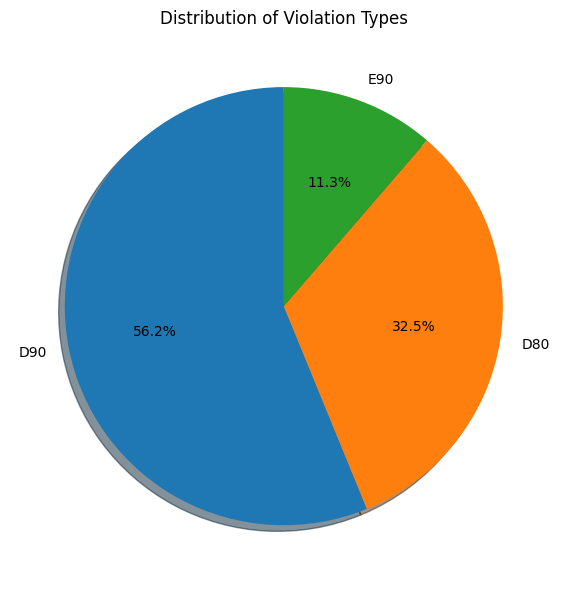

In [7]:
import matplotlib.pyplot as plt

violation_counts = notnanaics['VIOLATION_CODE'].value_counts()

plt.figure(figsize=(6, 6))
violation_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    shadow=True,
    labels=violation_counts.index
)

plt.title("Distribution of Violation Types")
plt.ylabel('')
plt.tight_layout()
plt.show()

So, from these we can see that the Surface Coal Mining industry has an insane number of violations. Most other sectors had similar violations box plots, but sector 2 was the worst. This could be due to the amount of Surface Coal Mines, otherwise it could be due to a lack of care when disposing of wastewater. This makes me wonder: are violations and NAICS_3digit code correlated? I will run a correlation test to find out.

In [8]:
from scipy.stats import kstest

stat, p = kstest(subset['violation_count'], 'norm')
print(f'Statistic={stat}, p-value={p}')
print(f'Since the p-value is < 0.05, we can determine that the data is not normally distributed.')

Statistic=0.9559183061976726, p-value=0.0
Since the p-value is < 0.05, we can determine that the data is not normally distributed.


In [9]:
import pandas as pd
from scipy.stats import kruskal

statistic, p_value = kruskal(*subset)

print(f"Kruskal-Wallis H-statistic: {statistic}")
print(f"P-value: {p_value}")
print(f'Since the p-value is > 0.05, we can determine that the NAICS 3 digit code does not have a significant impact on the amount of violations. I would then assume that the Surface Coal Mining industry just has a large number of violations due to their practices or lack of care.')

Kruskal-Wallis H-statistic: 3.0
P-value: 0.3916251762710884
Since the p-value is > 0.05, we can determine that the NAICS 3 digit code does not have a significant impact on the amount of violations. I would then assume that the Surface Coal Mining industry just has a large number of violations due to their practices or lack of care.


Now, I will look into the utility sector. That is those with NAICS code 221. With this, I will divide the violations by number of facilities in this sector. I am making the assumption that the utility sector has a bit more regulations and eyes on it, so they will be our 'baseline' to compare other sectors to. With this baseline, I will be able to then compare other sectors and their violations to the utility sector, to see what areas have room for improvement, or which ones do better than utilities.

In [4]:
notnanaics

#NEED TO AVOID ISSUE OF INCORRECT DATAFRAME W SIZE

,NPDES_ID,NPDES_VIOLATION_ID,VIOLATION_TYPE_CODE,VIOLATION_CODE,NAICS_CODE,NAICS_DESC,NAICS_3digit
1,KY0043206,2401138979,NaN,D90,212111.0,Bituminous Coal and Lignite Surface Mining,212
2,KY0081213,2401362889,NaN,D90,531190.0,Lessors of Other Real Estate Property,531
3,ID0020346,20167905,NaN,D90,221320.0,Sewage Treatment Facilities,221
4,AL0002186,1600085299,NaN,D90,212312.0,Crushed and Broken Limestone Mining and Quarrying,212
5,AL0002810,1600122856,NaN,D90,311615.0,Poultry Processing,311
...,...,...,...,...,...,...,...
7148,KYGE40236,3652447549,NaN,D80,212111.0,Bituminous Coal and Lignite Surface Mining,212
7164,ALG670027,1801655131,NaN,D90,221210.0,Natural Gas Distribution,221
7170,KYGE40236,3659778482,NaN,D90,212111.0,Bituminous Coal and Lignite Surface Mining,212
7176,MIG081017,2601904495,NaN,D90,482111.0,Line-Haul Railroads,482
